## 5. Write a custom EncodingDecoding class

In [1]:
# use these magic spells to update your classes methods on-the-fly as you edit them:
%reload_ext autoreload
%autoreload 2
from pprint import pprint
from IPython.core.display import display, HTML, Markdown
import ipywidgets as widgets
# %run includeme.ipynb # include a notebook from this same directory
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_82206/3813857106.py:5: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Markdown


In this chapter we show how to create your very own EncoderDecoder class.

In order to evaluate your model with our framework, you need a model that works with the ``CompressAIEncoderDecoder`` class.  This was discussed in the CLI tutorial.  If you need more flexibility, you can write your own ``EncoderDecoder`` class and this is quite simple.

Here we demo a simple ``EncoderDecoder`` class that encodes & decodes using jpeg.

In [2]:
import logging, io, cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from compressai_vision.evaluation.pipeline import EncoderDecoder

In the constructor, instantiate a logger and save the provided quality parameter.

In [3]:
class JpegEncoderDecoder(EncoderDecoder):
    
    def __init__(self, qp=10):
        self.logger = logging.getLogger(self.__class__.__name__)
        self.qp=qp
        self.reset() # not used in this class

Define how the image is encoded + decoded and how the bitrate is calculated.  We are using BGR since it is the default input format for Detectron2 predictors.

In [4]:
    def BGR(self, bgr_image, tag=None):
        # bgr_image: numpy BGR24 image: (y,x,3)
        # tag could be used to identify images if we want to cache them
        # BGR -> RGB (as PIL works with RGB)
        rgb_image = bgr_image[:,:,::-1]
        pil_img=Image.fromarray(rgb_image).convert("RGB")
        tmp = io.BytesIO()
        # encode image
        pil_img.save(tmp, format="jpeg", quality=self.qp)
        tmp.seek(0)
        # calculate bits-per-pixel
        filesize = tmp.getbuffer().nbytes
        bpp = filesize * float(8) / (pil_img.size[0] * pil_img.size[1])
        # decode image back
        pil_img2 = Image.open(tmp).convert("RGB")
        # back to BGR
        rgb_image=np.array(pil_img2)
        bgr_image=rgb_image[:,:,::-1]
        # transformed image, bits-per-pixel ready
        return bgr_image, bpp

In [5]:
# monkey-patch the class (this way it was nicer to write the tutorial)
# this cell will be hidden with the "remove_cell" tag
JpegEncoderDecoder.BGR=BGR

So, we have a compact class that defines, in a single method, all necessary transformations and calculates the bitrate.  

Once you define an ``EncoderDecoder`` class like this, you can use it with all the rest of the infrastructure provided by ``CompressAI-Vision`` library.

Next, let's see ``JpegEncoderDecoder`` in action.

In [6]:
bgr_image=cv2.imread("dog_512.png")

In [7]:
encdec=JpegEncoderDecoder(qp=1)

In [8]:
transformed_bgr_image, bpp = encdec.BGR(bgr_image)

Print bits-per-pixel, compare original and transformed image

BPP= 0.16878255208333334


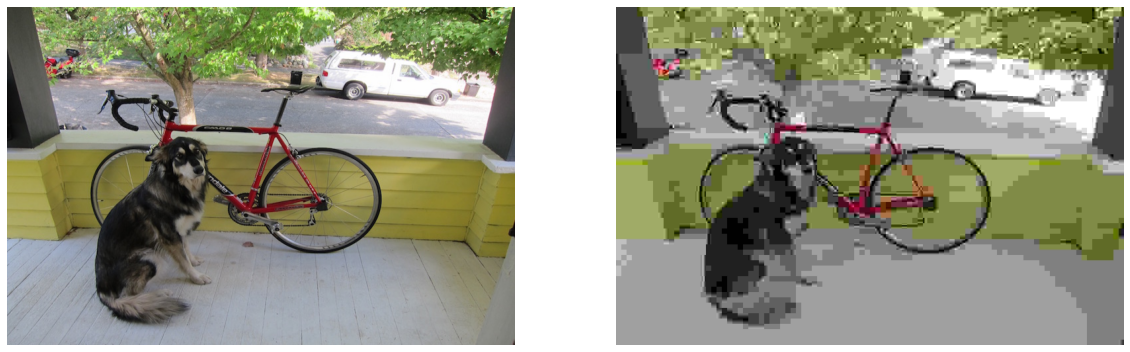

In [9]:
print("BPP=", bpp)
plt.figure(figsize=(20,20))
plt.subplot(1,2,1); plt.imshow(bgr_image[:,:,::-1]); _=plt.axis('off')
plt.subplot(1,2,2); plt.imshow(transformed_bgr_image[:,:,::-1]); _=plt.axis('off')